In [1]:
import pandas as pd
import wandb
from tqdm.notebook import tqdm
import pickle
from os.path import exists
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import math
from matplotlib.ticker import MaxNLocator

from data.get_uci import all_datasets
from analysis.util import fetch, init_uci_dict, get_uci_info, COLORS, uci_markers
uci_info = get_uci_info()

In [2]:
filters = {
    "group": "inducing2"
}
raw2 = fetch("soft-gp-2", filters)

100%|██████████| 274/274 [01:31<00:00,  2.98it/s]


In [3]:
runs = {}
uci_dict2 = {}
for exp in raw2:
    model = exp.config["model.name"]
    dataset = exp.config["dataset.name"]
    num_inducing = exp.config["model.num_inducing"]
    dtype = exp.config["model.dtype"]
    seed = exp.config["training.seed"]
    learn_noise = exp.config["model.learn_noise"]
    train_frac = float(exp.config["dataset.train_frac"])
    batch_size = exp.config["training.batch_size"]
    uci_dict2[(dataset, batch_size, num_inducing, model)] = exp.history
    runs[(dataset, batch_size, num_inducing, model)] = exp.run.id

print(uci_dict2.keys())

dict_keys([('houseelectric', 1024, 128, 'soft-gp'), ('houseelectric', 1024, 64, 'soft-gp'), ('houseelectric', 1024, 4096, 'soft-gp'), ('houseelectric', 1024, 2048, 'soft-gp'), ('houseelectric', 1024, 1536, 'soft-gp'), ('houseelectric', 1024, 1024, 'soft-gp'), ('houseelectric', 1024, 512, 'soft-gp'), ('houseelectric', 1024, 256, 'soft-gp'), ('buzz', 1024, 4096, 'soft-gp'), ('buzz', 1024, 2048, 'soft-gp'), ('buzz', 1024, 1536, 'soft-gp'), ('buzz', 1024, 1024, 'soft-gp'), ('buzz', 1024, 512, 'soft-gp'), ('buzz', 1024, 256, 'soft-gp'), ('buzz', 1024, 128, 'soft-gp'), ('buzz', 1024, 64, 'soft-gp'), ('song', 1024, 4096, 'soft-gp'), ('song', 1024, 2048, 'soft-gp'), ('song', 1024, 1536, 'soft-gp'), ('song', 1024, 1024, 'soft-gp'), ('song', 1024, 512, 'soft-gp'), ('song', 1024, 256, 'soft-gp'), ('song', 1024, 128, 'soft-gp'), ('song', 1024, 64, 'soft-gp'), ('3droad', 1024, 4096, 'soft-gp'), ('3droad', 1024, 2048, 'soft-gp'), ('3droad', 1024, 1536, 'soft-gp'), ('3droad', 1024, 1024, 'soft-gp'), 

In [4]:
UCI_INFO = {
    "N": [int(np.floor(N * 0.9)) for _, N, _, _ in uci_info],
    "D": [D for _, _, D, _ in uci_info],
    # "exact-rep": [e for _, _, _, e in uci_info],
}
KZZ = {}
all_bins = {}

seeds = [6535, 8830, 92357]
num_inducings = [64, 128, 256, 512, 1024, 1024 + 512, 2048, 4096]

# models = ["sv-gp"]
for seed in seeds:
    for num_inducing in num_inducings:
        model = "soft-gp"
        batch_size = 1024
        frac = 0.9
        xs = []
        ts = []
        K_zzs = []
        bins1 = []
        bins2 = []
        bins3 = []
        bins4 = []
        bins5 = []
        bins6 = []
        for dataset, _, _, _ in uci_info:
            try:
                xs += [float(uci_dict2[(dataset, batch_size, num_inducing, model)]["test_rmse"][49])]
                ts += [float(np.array(uci_dict2[(dataset, batch_size, num_inducing, model)]["epoch_time"][49]).mean())]
                K_zzs += [uci_dict2[(dataset, batch_size, num_inducing, model)]["K_zz"][i] for i in range(5)]
                bins1 += [uci_dict2[(dataset, batch_size, num_inducing, model)]["K_zz_bin_0.0"][49]]
                bins2 += [uci_dict2[(dataset, batch_size, num_inducing, model)]["K_zz_bin_1e-20"][49]]
                bins3 += [uci_dict2[(dataset, batch_size, num_inducing, model)]["K_zz_bin_1e-10"][49]]
                bins4 += [uci_dict2[(dataset, batch_size, num_inducing, model)]["K_zz_bin_1e-05"][49]]
                bins5 += [uci_dict2[(dataset, batch_size, num_inducing, model)]["K_zz_bin_0.01"][49]]
                bins6 += [uci_dict2[(dataset, batch_size, num_inducing, model)]["K_zz_bin_0.5"][49]]
            except Exception as e:
                xs += [np.nan]
                ts += [np.nan]
                bins1 += [np.nan]
                bins2 += [np.nan]
                bins3 += [np.nan]
                bins4 += [np.nan]
                bins5 += [np.nan]
                bins6 += [np.nan]
                print("Exception", e, model, dataset)

        UCI_INFO[f"{model}-{num_inducing}-{batch_size}-{seed}"] = xs
        # UCI_INFO[f"time-{model}-{num_inducing}-{batch_size}-{seed}"] = ts
        all_bins[f"0.0-{model}-{num_inducing}-{batch_size}-{seed}"] = bins1
        all_bins[f"1e-20-{model}-{num_inducing}-{batch_size}-{seed}"] = bins2
        all_bins[f"1e-10-{model}-{num_inducing}-{batch_size}-{seed}"] = bins3
        all_bins[f"1e-05-{model}-{num_inducing}-{batch_size}-{seed}"] = bins4
        all_bins[f"0.01-{model}-{num_inducing}-{batch_size}-{seed}"] = bins5
        all_bins[f"0.5-{model}-{num_inducing}-{batch_size}-{seed}"] = bins6
        KZZ[f"kzz-{model}-{num_inducing}-{batch_size}-{seed}"] = K_zzs
df = pd.DataFrame(data=UCI_INFO)
df.index = [name for name, _, _, _ in uci_info]
# df.index = [name.capitalize().replace("_", "-") for name, _, _, _ in uci_info]
df

Exception 49 soft-gp buzz
Exception 49 soft-gp houseelectric
Exception 49 soft-gp buzz
Exception 49 soft-gp houseelectric
Exception 'test_rmse' soft-gp houseelectric
Exception 'test_rmse' soft-gp houseelectric
Exception 'test_rmse' soft-gp slice
Exception 'test_rmse' soft-gp buzz
Exception 'test_rmse' soft-gp houseelectric
Exception 49 soft-gp buzz
Exception 49 soft-gp houseelectric
Exception 49 soft-gp buzz
Exception 49 soft-gp houseelectric
Exception 'test_rmse' soft-gp houseelectric
Exception 'test_rmse' soft-gp houseelectric
Exception 'test_rmse' soft-gp slice
Exception 'test_rmse' soft-gp buzz
Exception 'test_rmse' soft-gp houseelectric
Exception 49 soft-gp buzz
Exception 49 soft-gp houseelectric
Exception 49 soft-gp buzz
Exception 49 soft-gp houseelectric
Exception 'test_rmse' soft-gp houseelectric
Exception 'test_rmse' soft-gp houseelectric
Exception 'test_rmse' soft-gp slice
Exception 'test_rmse' soft-gp buzz
Exception 'test_rmse' soft-gp houseelectric


,N,D,soft-gp-64-1024-6535,soft-gp-128-1024-6535,soft-gp-256-1024-6535,soft-gp-512-1024-6535,soft-gp-1024-1024-6535,soft-gp-1536-1024-6535,soft-gp-2048-1024-6535,soft-gp-4096-1024-6535,...,soft-gp-2048-1024-8830,soft-gp-4096-1024-8830,soft-gp-64-1024-92357,soft-gp-128-1024-92357,soft-gp-256-1024-92357,soft-gp-512-1024-92357,soft-gp-1024-1024-92357,soft-gp-1536-1024-92357,soft-gp-2048-1024-92357,soft-gp-4096-1024-92357
pol,13500,26,0.243479,0.224857,0.200016,0.189091,0.188740,0.189551,0.192317,0.191455,...,0.192317,0.191455,0.243479,0.224857,0.200016,0.189091,0.188740,0.189551,0.192317,0.191455
elevators,14939,18,0.368108,0.373503,0.383927,0.391183,0.389627,0.388455,0.388598,0.393480,...,0.388598,0.393480,0.368108,0.373503,0.383927,0.391183,0.389627,0.388455,0.388598,0.393480
bike,15641,17,0.187631,0.184572,0.192533,0.207341,0.213647,0.218749,0.221110,0.221708,...,0.221110,0.221708,0.187631,0.184572,0.192533,0.207341,0.213647,0.218749,0.221110,0.221708
kin40k,36000,8,0.329381,0.287522,0.256036,0.242823,0.235800,0.234510,0.232643,0.233327,...,0.232643,0.233327,0.329381,0.287522,0.256036,0.242823,0.235800,0.234510,0.232643,0.233327
protein,41157,9,0.693394,0.660875,0.657398,0.657370,0.657834,0.655753,0.655409,0.655083,...,0.655409,0.655083,0.693394,0.660875,0.657398,0.657370,0.657834,0.655753,0.655409,0.655083
keggdirected,43944,20,0.090282,0.083722,0.079800,0.078657,0.079594,0.079406,0.079989,0.080183,...,0.079989,0.080183,0.090282,0.083722,0.079800,0.078657,0.079594,0.079406,0.079989,0.080183
slice,48150,385,0.093395,0.065097,0.054857,0.051255,0.044698,0.041867,0.035696,NaN,...,0.035696,NaN,0.093395,0.065097,0.054857,0.051255,0.044698,0.041867,0.035696,NaN
keggundirected,57247,27,0.123503,0.119047,NaN,0.116266,0.116749,0.115749,0.115074,0.114999,...,0.115074,0.114999,0.123503,0.119047,NaN,0.116266,0.116749,0.115749,0.115074,0.114999
3droad,391386,3,0.631772,0.606538,0.608388,0.605115,0.608126,0.603669,0.609010,0.614328,...,0.609010,0.614328,0.631772,0.606538,0.608388,0.605115,0.608126,0.603669,0.609010,0.614328
song,270000,90,0.795940,0.795021,0.795939,0.798351,0.811035,0.812757,0.810868,0.811612,...,0.810868,0.811612,0.795940,0.795021,0.795939,0.798351,0.811035,0.812757,0.810868,0.811612


In [5]:
def pm_var(df, model):
    m = df[[f'{model}-6535', f'{model}-8830', f'{model}-92357']].mean(axis=1).round(3)
    # v = df[[f'{model}-6535', f'{model}-8830', f'{model}-92357']].std(axis=1).round(3).astype(str).apply(lambda x: f" $\pm$ {x}")
    # return (m + v).apply(lambda x: x.replace("nan $\pm$ nan", "-"))
    return m
df_rmse = pd.DataFrame()
df_rmse[['N', 'D']] = df[['N', 'D']]
for model in ["soft-gp"]:
    for num_inducing in num_inducings:
        frac = 0.9
        df_rmse[f'{model}-{num_inducing}-{1024}'] = pm_var(df, f'{model}-{num_inducing}-{1024}')

df_rmse = df_rmse.sort_values(by=['D'], ascending=[True])
df_rmse = df_rmse.drop(columns=['D', 'N'])
print("RMSE")
df_rmse

RMSE


,soft-gp-64-1024,soft-gp-128-1024,soft-gp-256-1024,soft-gp-512-1024,soft-gp-1024-1024,soft-gp-1536-1024,soft-gp-2048-1024,soft-gp-4096-1024
3droad,0.632,0.607,0.608,0.605,0.608,0.604,0.609,0.614
kin40k,0.329,0.288,0.256,0.243,0.236,0.235,0.233,0.233
protein,0.693,0.661,0.657,0.657,0.658,0.656,0.655,0.655
houseelectric,NaN,NaN,0.071,0.065,0.059,NaN,NaN,NaN
bike,0.188,0.185,0.193,0.207,0.214,0.219,0.221,0.222
elevators,0.368,0.374,0.384,0.391,0.390,0.388,0.389,0.393
keggdirected,0.090,0.084,0.080,0.079,0.080,0.079,0.080,0.080
pol,0.243,0.225,0.200,0.189,0.189,0.190,0.192,0.191
keggundirected,0.124,0.119,NaN,0.116,0.117,0.116,0.115,0.115
buzz,NaN,NaN,0.260,0.253,0.248,0.247,0.247,NaN


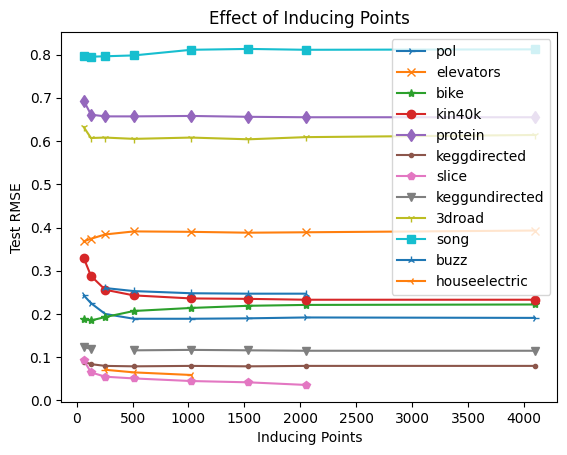

In [6]:
for dataset, _, _, _ in uci_info:
    # if dataset in ["3droad", "houseelectric", "keggundirected", "buzz", "song", "slice"]:
    #     continue
    plt.plot(num_inducings, df_rmse.loc[dataset,:], label=dataset, marker=uci_markers[dataset])
plt.legend()
plt.title("Effect of Inducing Points")
plt.xlabel("Inducing Points")
plt.ylabel("Test RMSE")
plt.savefig("inducing/inducing.png")
# plt.plot(num_inducings, df_rmse.loc["Kin40k",:])

In [7]:
model = "soft-gp"
num_inducing = 512
frac = 0.9
seed = 6535

bin_df = pd.DataFrame()
bin_df[['N', 'D']] = df[['N', 'D']]
# bin_df.index = [name.capitalize().replace("_", "-") for name, _, _, _ in uci_info]
for model_num_inducing in ["soft-gp-64", "soft-gp-128", "soft-gp-256", "soft-gp-512", "soft-gp-1024", "soft-gp-1536", "soft-gp-2048", "soft-gp-4096"]:
    num_inducing = int(model_num_inducing.split("-")[-1])
    total = num_inducing**2
    for b in ["0.0", "1e-20", "1e-10", "1e-05", "0.01", "0.5"]:
        bin_df[f"{b}-{model_num_inducing}-{1024}-{seed}"] = np.array(all_bins[f"{b}-{model_num_inducing}-{1024}-{seed}"]) / total
    # bin_df[f"1e-20-{model}-{num_inducing}-{frac}-{seed}"] = np.array(all_bins[f"1e-20-{model}-{num_inducing}-{frac}-{seed}"]) / (512**2)
bin_df = bin_df.sort_values(by=['D'], ascending=[True])
bin_df

,N,D,0.0-soft-gp-64-1024-6535,1e-20-soft-gp-64-1024-6535,1e-10-soft-gp-64-1024-6535,1e-05-soft-gp-64-1024-6535,0.01-soft-gp-64-1024-6535,0.5-soft-gp-64-1024-6535,0.0-soft-gp-128-1024-6535,1e-20-soft-gp-128-1024-6535,...,1e-10-soft-gp-2048-1024-6535,1e-05-soft-gp-2048-1024-6535,0.01-soft-gp-2048-1024-6535,0.5-soft-gp-2048-1024-6535,0.0-soft-gp-4096-1024-6535,1e-20-soft-gp-4096-1024-6535,1e-10-soft-gp-4096-1024-6535,1e-05-soft-gp-4096-1024-6535,0.01-soft-gp-4096-1024-6535,0.5-soft-gp-4096-1024-6535
3droad,391386,3,0.982910,0.000488,0.000000,0.000000,0.000000,0.000000,0.986328,0.000854,...,0.000900,4.768372e-07,0.000000,4.768372e-07,0.981873,0.004995,0.000421,0.000000,2.384186e-07,8.344650e-07
kin40k,36000,8,0.585449,0.300781,0.084473,0.009277,0.000000,0.015625,0.000000,0.007446,...,0.235267,9.749794e-02,0.174363,3.489065e-02,0.003667,0.086029,0.234264,0.093905,1.735376e-01,3.493297e-02
protein,41157,9,0.916504,0.046387,0.018555,0.001465,0.000000,0.015625,0.959839,0.025391,...,0.155706,3.620005e-02,0.024561,1.072741e-02,0.459079,0.223089,0.166642,0.038344,2.521169e-02,1.051652e-02
houseelectric,1844352,11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
bike,15641,17,0.000000,0.012695,0.143066,0.105957,0.149414,0.166504,0.000000,0.003906,...,0.357472,1.467948e-01,0.094956,1.646614e-02,0.000612,0.082235,0.412809,0.140149,7.082856e-02,1.404822e-02
elevators,14939,18,0.120117,0.014160,0.042480,0.041016,0.228516,0.164551,0.061890,0.023926,...,0.318068,1.194456e-01,0.102971,5.462646e-03,0.012751,0.134104,0.355058,0.114593,9.328723e-02,4.981756e-03
keggdirected,43944,20,0.146973,0.018066,0.085938,0.023926,0.130371,0.369141,0.121460,0.054443,...,0.153031,7.285452e-02,0.201421,5.691576e-02,0.032431,0.060879,0.150351,0.077587,2.116268e-01,5.317175e-02
pol,13500,26,0.972168,0.008301,0.002930,0.000000,0.000000,0.015625,0.984253,0.006104,...,0.052963,8.193970e-03,0.003444,1.284122e-03,0.616987,0.220759,0.103181,0.018317,7.761478e-03,1.942277e-03
keggundirected,57247,27,0.095703,0.052246,0.049805,0.027344,0.138672,0.322266,0.168457,0.055420,...,0.007220,2.139568e-03,0.001432,8.509636e-03,0.936739,0.028661,0.014874,0.004918,1.096964e-03,9.057879e-03
buzz,524925,77,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.000006,0.000000e+00,0.000000,0.000000e+00,NaN,NaN,NaN,NaN,NaN,NaN


In [8]:
colors = COLORS * 2
markers = ['x', 'o', '.'] * 3

for dataset in ["3droad", "kin40k", "protein", "houseelectric", "bike", "elevators", "keggdirected", "pol", "keggundirected", "buzz", "song", "slice"]:
    plt.figure()
    for model_num_inducing, c, m in zip(["soft-gp-64", "soft-gp-128", "soft-gp-256", "soft-gp-512", "soft-gp-1024", "soft-gp-1536", "soft-gp-2048", "soft-gp-4096"], colors, markers):
        bs = ["0.0", "1e-20", "1e-10", "1e-05", "0.01", "0.5"]
        # model_num_inducing = "soft-gp-512"
        num_inducing = int(model_num_inducing.split("-")[-1])
        style = "-" if num_inducing <= 1024 else ":"
        plt.plot(bs, [bin_df[f"{b}-{model_num_inducing}-{1024}-{seed}"][dataset] for b in bs], label=num_inducing, marker=m, color=c, linestyle=style)
    plt.legend()
    plt.title("Inducing")
    plt.ylabel("Proportion")
    plt.xlabel("Kernel Value")
    plt.savefig(f"inducing/{dataset}.png")
    plt.close()

In [9]:
UCI_INFO = {
    "N": [int(np.floor(N * 0.9)) for _, N, _, _ in uci_info],
    "D": [D for _, _, D, _ in uci_info],
    # "exact-rep": [e for _, _, _, e in uci_info],
}

seeds = [6535, 8830, 92357]
num_inducings = [64, 128, 256, 512, 1024, 1024 + 512, 2048, 4096]

# models = ["sv-gp"]
for seed in seeds:
    for num_inducing in num_inducings:
        model = "soft-gp"
        batch_size = 1024
        frac = 0.9
        xs = []
        ts = []
        K_zzs = []
        norm1 = []
        for dataset, _, _, _ in uci_info:
            try:
                xs += [float(uci_dict2[(dataset, batch_size, num_inducing, model)]["test_rmse"][49])]
                ts += [float(np.array(uci_dict2[(dataset, batch_size, num_inducing, model)]["epoch_time"][49]).mean())]
                K_zzs += [uci_dict2[(dataset, batch_size, num_inducing, model)]["K_zz"][i] for i in range(5)]
                norm1 += [float(uci_dict2[(dataset, batch_size, num_inducing, model)]["K_zz_norm_1"][49])]
            except Exception as e:
                xs += [np.nan]
                ts += [np.nan]
                norm1 += [np.nan]
                print("Exception", e, model, dataset)

        UCI_INFO[f"{model}-{num_inducing}-{batch_size}-{seed}"] = norm1
        # UCI_INFO[f"time-{model}-{num_inducing}-{batch_size}-{seed}"] = ts
df = pd.DataFrame(data=UCI_INFO)
df.index = [name for name, _, _, _ in uci_info]
# df.index = [name.capitalize().replace("_", "-") for name, _, _, _ in uci_info]
df

Exception 49 soft-gp buzz
Exception 49 soft-gp houseelectric
Exception 49 soft-gp buzz
Exception 49 soft-gp houseelectric
Exception 'test_rmse' soft-gp houseelectric
Exception 'test_rmse' soft-gp houseelectric
Exception 'test_rmse' soft-gp slice
Exception 'test_rmse' soft-gp buzz
Exception 'test_rmse' soft-gp houseelectric
Exception 49 soft-gp buzz
Exception 49 soft-gp houseelectric
Exception 49 soft-gp buzz
Exception 49 soft-gp houseelectric
Exception 'test_rmse' soft-gp houseelectric
Exception 'test_rmse' soft-gp houseelectric
Exception 'test_rmse' soft-gp slice
Exception 'test_rmse' soft-gp buzz
Exception 'test_rmse' soft-gp houseelectric
Exception 49 soft-gp buzz
Exception 49 soft-gp houseelectric
Exception 49 soft-gp buzz
Exception 49 soft-gp houseelectric
Exception 'test_rmse' soft-gp houseelectric
Exception 'test_rmse' soft-gp houseelectric
Exception 'test_rmse' soft-gp slice
Exception 'test_rmse' soft-gp buzz
Exception 'test_rmse' soft-gp houseelectric


,N,D,soft-gp-64-1024-6535,soft-gp-128-1024-6535,soft-gp-256-1024-6535,soft-gp-512-1024-6535,soft-gp-1024-1024-6535,soft-gp-1536-1024-6535,soft-gp-2048-1024-6535,soft-gp-4096-1024-6535,...,soft-gp-2048-1024-8830,soft-gp-4096-1024-8830,soft-gp-64-1024-92357,soft-gp-128-1024-92357,soft-gp-256-1024-92357,soft-gp-512-1024-92357,soft-gp-1024-1024-92357,soft-gp-1536-1024-92357,soft-gp-2048-1024-92357,soft-gp-4096-1024-92357
pol,13500,26,4.970294,4.525251,4.396865,8.325789,16.117550,24.484951,39.497036,114.152794,...,39.497036,114.152794,4.970294,4.525251,4.396865,8.325789,16.117550,24.484951,39.497036,114.152794
elevators,14939,18,45.820244,49.222599,47.331654,51.586010,89.710793,144.813629,192.875580,361.173492,...,192.875580,361.173492,45.820244,49.222599,47.331654,51.586010,89.710793,144.813629,192.875580,361.173492
bike,15641,17,59.399651,98.886658,184.271133,255.540863,278.569122,303.816254,359.042084,652.972473,...,359.042084,652.972473,59.399651,98.886658,184.271133,255.540863,278.569122,303.816254,359.042084,652.972473
kin40k,36000,8,7.614863,21.516146,49.078186,101.582794,206.591614,317.779266,449.193573,872.043945,...,449.193573,872.043945,7.614863,21.516146,49.078186,101.582794,206.591614,317.779266,449.193573,872.043945
protein,41157,9,10.846959,21.515808,76.737297,154.954544,275.967407,393.253571,637.520874,1196.539551,...,637.520874,1196.539551,10.846959,21.515808,76.737297,154.954544,275.967407,393.253571,637.520874,1196.539551
keggdirected,43944,20,107.984673,157.775543,157.775375,274.250763,379.299255,629.701294,739.193115,1319.407104,...,739.193115,1319.407104,107.984673,157.775543,157.775375,274.250763,379.299255,629.701294,739.193115,1319.407104
slice,48150,385,5.056293,2.227203,1.523783,1.496918,1.329851,1.356874,109.170601,NaN,...,109.170601,NaN,5.056293,2.227203,1.523783,1.496918,1.329851,1.356874,109.170601,NaN
keggundirected,57247,27,98.667381,67.912704,36.333160,124.675049,341.364624,778.471924,743.012573,1333.708130,...,743.012573,1333.708130,98.667381,67.912704,36.333160,124.675049,341.364624,778.471924,743.012573,1333.708130
3droad,391386,3,247.038177,392.232056,789.174988,1720.758179,3421.805664,4891.406738,6356.673340,13856.290039,...,6356.673340,13856.290039,247.038177,392.232056,789.174988,1720.758179,3421.805664,4891.406738,6356.673340,13856.290039
song,270000,90,52.241112,66.093025,70.963776,74.189293,81.474739,81.416382,80.646584,158.789429,...,80.646584,158.789429,52.241112,66.093025,70.963776,74.189293,81.474739,81.416382,80.646584,158.789429


In [10]:
def pm_var(df, model):
    m = df[[f'{model}-6535', f'{model}-8830', f'{model}-92357']].mean(axis=1).round(3)
    # v = df[[f'{model}-6535', f'{model}-8830', f'{model}-92357']].std(axis=1).round(3).astype(str).apply(lambda x: f" $\pm$ {x}")
    # return (m + v).apply(lambda x: x.replace("nan $\pm$ nan", "-"))
    return m
df_matnorm = pd.DataFrame()
df_matnorm[['N', 'D']] = df[['N', 'D']]
for model in ["soft-gp"]:
    for num_inducing in num_inducings:
        frac = 0.9
        df_matnorm[f'{model}-{num_inducing}-{1024}'] = pm_var(df, f'{model}-{num_inducing}-{1024}')

df_matnorm = df_matnorm.sort_values(by=['D'], ascending=[True])
df_matnorm = df_matnorm.drop(columns=['D', 'N'])
df_matnorm

,soft-gp-64-1024,soft-gp-128-1024,soft-gp-256-1024,soft-gp-512-1024,soft-gp-1024-1024,soft-gp-1536-1024,soft-gp-2048-1024,soft-gp-4096-1024
3droad,247.038,392.232,789.175,1720.758,3421.806,4891.407,6356.673,13856.290
kin40k,7.615,21.516,49.078,101.583,206.592,317.779,449.194,872.044
protein,10.847,21.516,76.737,154.955,275.967,393.254,637.521,1196.540
houseelectric,NaN,NaN,2900.510,9567.813,15825.072,NaN,NaN,NaN
bike,59.400,98.887,184.271,255.541,278.569,303.816,359.042,652.972
elevators,45.820,49.223,47.332,51.586,89.711,144.814,192.876,361.173
keggdirected,107.985,157.776,157.775,274.251,379.299,629.701,739.193,1319.407
pol,4.970,4.525,4.397,8.326,16.118,24.485,39.497,114.153
keggundirected,98.667,67.913,36.333,124.675,341.365,778.472,743.013,1333.708
buzz,NaN,NaN,184.252,188.955,781.364,1178.126,2158.026,NaN


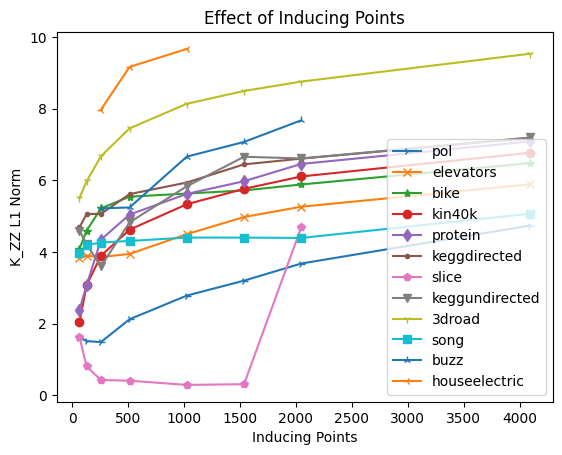

In [12]:
for dataset, _, _, _ in uci_info:
    # if dataset in ["3droad", "houseelectric", "keggundirected", "buzz", "song", "slice"]:
    #     continue
    plt.plot(num_inducings, np.log(df_matnorm.loc[dataset,:]), label=dataset, marker=uci_markers[dataset])
plt.legend()
plt.title("Effect of Inducing Points")
plt.xlabel("Inducing Points")
plt.ylabel("K_ZZ L1 Norm")
plt.savefig("inducing/matnorm.png")